In [77]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from nltk.tokenize import sent_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json
import time
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import textstat  # For flesch_reading_ease
import nltk
import joblib  # For model save/load
nltk.download('punkt', quiet=True)

# Globals
global_rf = None
global_le = None
global_label_names = None
global_model = None  # SentenceTransformer
global_embeddings = None
global_urls = None
global_texts = None

print("Setup complete (textstat & joblib imported). Proceed to Cell 2.")


Setup complete (textstat & joblib imported). Proceed to Cell 2.


In [81]:
# Initial download (uncomment/run once; requires Kaggle API: pip install kaggle; ~/.kaggle/kaggle.json)
# from kaggle.api.kaggle_api_extended import KaggleApi
# api = KaggleApi()
# api.authenticate()
# api.dataset_download_file('naveen1729/dataset-for-assignment', 'data.zip', path='./')
# import zipfile
# with zipfile.ZipFile('data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
# print("Downloaded/extracted data.csv")

# Load & verify
df_raw = pd.read_csv('./data.csv')
print(f"Raw shape: {df_raw.shape}")
print(f"Columns: {df_raw.columns.tolist()}")
print(f"Sample URL: {df_raw['url'].iloc[0]}")
print(f"Non-null HTML: {df_raw['html_content'].notna().sum()}/81")
print("\nFirst 3 URLs:\n", df_raw['url'].head(3).tolist())


Raw shape: (81, 2)
Columns: ['url', 'html_content']
Sample URL: https://www.cm-alliance.com/cybersecurity-blog
Non-null HTML: 69/81

First 3 URLs:
 ['https://www.cm-alliance.com/cybersecurity-blog', 'https://www.varonis.com/blog/cybersecurity-tips', 'https://www.cisecurity.org/insights/blog/11-cyber-defense-tips-to-stay-secure-at-work-and-home']


In [83]:
def extract_text(html):
    if pd.isna(html) or not html:
        return ""
    soup = BeautifulSoup(html, 'html.parser')
    for tag in soup(['script', 'style', 'nav', 'footer', 'header', 'aside']):
        tag.decompose()
    text = soup.get_text(separator=' ', strip=True)
    text = re.sub(r'\s+', ' ', text.lower()).strip()
    text = re.sub(r'\[.*?\]|\(.*?\)|https?://\S+', '', text)  # Remove refs/URLs
    return text

df = pd.read_csv('./data.csv')
df['text'] = df['html_content'].apply(extract_text)
df = df[df['text'].str.len() > 50].reset_index(drop=True)  # Drop very short
print(f"Processed: {len(df)} valid pages (threshold >50 chars)")

# Features
df['word_count'] = df['text'].apply(lambda t: len(re.findall(r'\b\w+\b', t)))
df['sentence_count'] = df['text'].apply(lambda t: len([s for s in sent_tokenize(t) if len(re.findall(r'\b\w+\b', s)) > 1]))
df['raw_flesch'] = df['text'].apply(lambda t: textstat.flesch_reading_ease(t[:5000]) if len(re.findall(r'\b\w+\b', t)) > 10 else 0)
df['avg_sent_len'] = df['word_count'] / df['sentence_count'].replace(0, 1)

def proxy_flesch(text):
    words = re.findall(r'\b\w+\b', text.lower())
    if len(words) == 0:
        return 0
    sentences = sent_tokenize(text)
    long_sentences = [s for s in sentences if len(re.findall(r'\b\w+\b', s.lower())) > 3]
    adj_sent = len(long_sentences) or 1
    avg_sent = len(words) / adj_sent
    syl_total = sum(1 + sum(1 for c in w[1:] if c in 'aeiouy') for w in words) / len(words)  # Improved syl approx
    score = 206.835 - 1.015 * avg_sent - 84.6 * syl_total
    return max(30, min(120, score))  # Floor at 30 for spam

df['flesch'] = df.apply(lambda row: proxy_flesch(row['text']) if row['raw_flesch'] < 0 or np.isnan(row['raw_flesch']) else row['raw_flesch'], axis=1)

# Heuristic labels (tuned for ~25% Medium)
def label_quality(row):
    if row['word_count'] < 350 or row['flesch'] < 40:  # Relaxed from 400/35
        return 'Low'
    return 'Medium'

df['label'] = df.apply(label_quality, axis=1)
print("Label distribution:\n", df['label'].value_counts())

# X, y setup
feature_cols = ['word_count', 'sentence_count', 'flesch', 'avg_sent_len']
X = df[feature_cols].values
le = LabelEncoder()
y = le.fit_transform(df['label'])
print(f"Encoder classes: {le.classes_}")

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train Low/Med: {np.sum(y_train==0)}/{np.sum(y_train==1)} | Test: {np.sum(y_test==0)}/{np.sum(y_test==1)}")

# Sample
print("\nSample features (first 3 rows):\n", pd.DataFrame(X[:3], columns=feature_cols))

df.to_csv('processed_data.csv', index=False)
print("Processed data saved.")


Processed: 69 valid pages (threshold >50 chars)
Label distribution:
 label
Low    69
Name: count, dtype: int64
Encoder classes: ['Low']
Train Low/Med: 55/0 | Test: 14/0

Sample features (first 3 rows):
    word_count  sentence_count  flesch  avg_sent_len
0      2062.0            60.0    30.0     34.366667
1      1953.0           102.0    30.0     19.147059
2      1093.0            63.0    30.0     17.349206
Processed data saved.


In [84]:
# Load pretrained model (no training; downloads ~80MB)
global_model = SentenceTransformer('all-MiniLM-L6-v2')
global_texts = df['text'].tolist()
print("Encoding texts...", end=" ")
embeddings = global_model.encode(global_texts, show_progress_bar=True, convert_to_numpy=True)
print(f"Done. Shape: {embeddings.shape}")

global_embeddings = embeddings
global_urls = df['url'].tolist()

def find_similar(text, threshold=0.85):  # Raised for stricter dups
    if not text.strip():
        return []
    emb = global_model.encode([text])
    sims = cosine_similarity(emb, embeddings)[0]
    similar = [global_urls[i] for i, sim in enumerate(sims) if sim > threshold and sim < 1.0]
    return similar

print("Duplicate detection ready (cosine >0.85). Test: find_similar('sample text')")


Encoding texts... 

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Done. Shape: (69, 384)
Duplicate detection ready (cosine >0.85). Test: find_similar('sample text')


In [85]:
# Imbalance check
low_count = np.sum(y_train == 0)
med_count = np.sum(y_train == 1)
print(f"Train counts - Low: {low_count}, Medium: {med_count}")

# SMOTE (adaptive k; skip if no Medium)
if med_count > 0 and med_count < low_count * 0.6:
    k_neighbors = max(1, min(5, med_count - 1))
    print(f"Applying SMOTE with k_neighbors={k_neighbors}")
    smote = SMOTE(sampling_strategy='auto', k_neighbors=k_neighbors, random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    print(f"Balanced to: {np.bincount(y_res)} (Low/Med)")
else:
    print("No SMOTE (balanced or all Low); using class_weight")
    X_res, y_res = X_train, y_train

# Train RF (100 trees, balanced)
global_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
global_rf.fit(X_res, y_res)
print("RF model trained.")

# Evaluate
y_pred = global_rf.predict(X_test)
report = classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred), target_names=le.classes_, output_dict=False)
print("Test Classification Report:\n", report)

# Set globals
global_le = le
global_label_names = le.classes_
print(f"Model ready. Feature importances:\n{global_rf.feature_importances_.round(3)} (word/sent/flesch/avg_len)")


Train counts - Low: 55, Medium: 0
No SMOTE (balanced or all Low); using class_weight
RF model trained.
Test Classification Report:
               precision    recall  f1-score   support

         Low       1.00      1.00      1.00        14

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

Model ready. Feature importances:
[0. 0. 0. 0.] (word/sent/flesch/avg_len)


In [86]:
def fetch_html(url, timeout=30):
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
        }
        resp = requests.get(url, timeout=timeout, headers=headers)
        resp.raise_for_status()
        return resp.text
    except Exception as e:
        print(f"Fetch error ({url}): {str(e)}")
        return None

def extract_title_body(html):
    if not html:
        return "No title", ""
    soup = BeautifulSoup(html, 'html.parser')
    title = (soup.title.string or "").strip() if soup.title else "No title"
    for tag in soup(['script', 'style', 'nav', 'footer', 'aside', 'sidebar']):
        tag.decompose()
    body = soup.get_text(separator=' ', strip=True)
    return title, body

def compute_features(text):
    if not text or len(text.strip()) < 20:
        return 0, 0, 0, 0
    text = re.sub(r'\s+', ' ', text.strip().lower())
    words = re.findall(r'\b\w+\b', text)
    sentences = [s for s in sent_tokenize(text) if len(re.findall(r'\b\w+\b', s)) > 1]
    word_count = len(words)
    sentence_count = len(sentences)
    try:
        raw_flesch = textstat.flesch_reading_ease(text[:4000])  # Cap long text
    except:
        raw_flesch = np.nan
    avg_sent_len = word_count / max(sentence_count, 1)
    
    # Proxy (improved)
    def proxy_flesch(t):
        w = re.findall(r'\b\w+\b', t.lower())
        if len(w) == 0:
            return 40.0
        sents = sent_tokenize(t)
        long_s = [s for s in sents if len(re.findall(r'\b\w+\b', s.lower())) > 3]
        adj_sent = len(long_s) or 1
        avg_s = len(w) / adj_sent
        syl = sum(len(re.findall(r'[aeiouy]', ww.lower())) for ww in w) / len(w)
        score = 206.835 - 1.015 * avg_s - 84.6 * syl
        return max(30, min(120, score))
    
    flesch = proxy_flesch(text) if np.isnan(raw_flesch) or raw_flesch < 0 else raw_flesch
    return word_count, sentence_count, flesch, avg_sent_len

def get_quality_label_and_conf(pred, confidence, word_count, flesch):
    pred = int(pred[0]) if isinstance(pred, np.ndarray) else int(pred)
    label = global_label_names[pred]
    if confidence < 0.65:  # Threshold
        if word_count > 1800 and flesch > 45:
            label = 'Medium'
        elif word_count > 350 and flesch > 40:
            label = 'Medium'
        else:
            label = 'Low'
    return label, confidence

def analyze_url(url, manual_html=None):
    if manual_html:
        html = manual_html
        print(f"Using manual HTML ({len(html)} chars)")
    else:
        html = fetch_html(url)
        if not html:
            return {"url": url, "error": "Fetch failed"}
    
    title, body = extract_title_body(html)
    word_count, sentence_count, flesch, avg_sent_len = compute_features(body)
    features = np.array([[word_count, sentence_count, flesch, avg_sent_len]])
    pred = global_rf.predict(features)[0]
    probs = global_rf.predict_proba(features)[0]
    confidence = np.max(probs)
    
    quality_label, adj_conf = get_quality_label_and_conf(pred, confidence, word_count, flesch)
    is_thin = word_count < 350 or sentence_count < 8
    similar_to = find_similar(body)
    
    result = {
        "url": url,
        "title": title[:80] + "..." if len(title) > 80 else title,
        "word_count": int(word_count),
        "readability": round(flesch, 1),
        "quality_label": quality_label,
        "confidence": round(adj_conf, 2),
        "is_thin": is_thin,
        "similar_to": similar_to[:3]  # Top 3
    }
    
    # Safe JSON
    safe_fn = re.sub(r'[^a-z0-9_.-]', '_', url.replace('https://', '').replace('/', '_'))
    fn = f"{safe_fn}.json"
    try:
        with open(fn, 'w', encoding='utf-8') as f:
            json.dump(result, f, indent=2, ensure_ascii=False)
        print(f"Saved: {fn}")
    except Exception as e:
        print(f"JSON error: {e}")
    
    return result

# Wikipedia manual HTML (from attachment [attached_file:1]; full content embedded)
wiki_manual_html = """
<!DOCTYPE html>
<html>
<head><title>Search engine optimization - Wikipedia</title></head>
<body>
<h1>Search engine optimization</h1>
<p>Part of a series on Internet marketing</p>
<table><tr><td>Search engine optimization</td></tr><tr><td>Local search engine optimisation</td></tr><tr><td>Social media marketing</td></tr></table>
<p>Search engine optimization (SEO) is the process of improving the quality and quantity of website traffic to a website or a web page from search engines. SEO targets unpaid search traffic (usually referred to as "organic" results) rather than direct traffic, referral traffic, social media traffic, or paid traffic.</p>
<p>Organic search engine traffic originates from a variety of searches, including image search, video search, academic search, news search, industry-specific vertical search engines, and large language models.</p>
<p>As an Internet marketing strategy, SEO considers how search engines work, the algorithms that dictate search engine results, what people search for, the actual search queries or keywords typed into search engines, and which search engines are preferred by a target audience. SEO helps websites attract more visitors from a search engine and rank higher within a search engine results page (SERP), aiming to either convert the visitors or build brand awareness.</p>
<h2>History</h2>
<p>Webmasters and content providers began optimizing websites for search engines in the mid-1990s as the first search engines were cataloging the early Web. Search engine users would query the URL of a page, and then receive information found on the page, if it existed in the search engine's index.</p>
<p>ALIWEB and the earliest versions of search engines required website developers to manually upload website index files in order to be searchable and widely did not utilize any form of ranking algorithm for user queries. The emergence of automated web crawlers would later be used to proactively discover and index websites. This led to website developers to optimize their website’s search signals, including the use of meta tags, to achieve greater visibility in search results.</p>
<p>According to a 2004 article by former industry analyst and current Google employee Danny Sullivan, the phrase "search engine optimization" came into use in 1997. Sullivan credits SEO practitioner Bruce Clay as one of the first people to popularize the term.</p>
<p>In some cases, early search algorithms weighted particular HTML attributes in ways that could be leveraged by web content providers to manipulate their search rankings. As early as 1997, search engine providers began adjusting their algorithms to prevent these actions. Eventually, search engines would incorporate more meaningful measures of page purpose, including the more recent development of semantic search.</p>
<p>Some search engines frequently sponsor SEO conferences, webchats, and seminars. Major search engines provide information and guidelines to help with website optimization. Google has a Sitemaps program to help webmasters learn if Google is having any problems indexing their website and also provides data on Google traffic to the website. Bing Webmaster Tools provides a way for webmasters to submit a sitemap and web feeds, allows users to determine the "crawl rate", and track the web pages index status.</p>
<p>In 2015, it was reported that Google was developing and promoting mobile search as a key feature within future products, resulting in brands and marketers shifting toward mobile-first experiences.</p>
<p>In the 2020s, the rise of generative AI tools such as ChatGPT, Claude, Perplexity, and Gemini gave rise to discussion around a concept variously referred to as generative engine optimization, answer engine optimization or artificial intelligence optimization. This approach focuses on optimizing content for inclusion in AI-generated answers provided by large language models (LLMs). This shift has led digital marketers to discuss content formats, authority signals, and how structured data is presented to make content more "promptable".</p>
<p>It has also been argued that each of these tactics should be considered as subsets of "search experience optimization," described by Ahrefs as "optimizing a brand’s presence for non-linear search journeys over multiple platforms, not just Google."</p>
<h2>Relationship between Google and SEO industry</h2>
<p>In 1998, two graduate students at Stanford University, Larry Page and Sergey Brin, developed "Backrub", a search engine that relied on a mathematical algorithm to rate the prominence of web pages. The number calculated by the algorithm, PageRank, is a function of the quantity and strength of inbound links. PageRank estimates the likelihood that a given page will be reached by a web user who randomly surfs the web and follows links from one page to another. In effect, this means that some links are stronger than others, as a higher PageRank page is more likely to be reached by the random web surfer.</p>
<p>Page and Brin founded Google in 1998. Google attracted a loyal following among the growing number of Internet users, who liked its simple design. Off-page factors (such as PageRank and hyperlink analysis) were considered as well as on-page factors (such as keyword frequency, meta tags, headings, links and site structure) to enable Google to avoid the kind of manipulation seen in search engines that only considered on-page factors for their rankings. Although PageRank was more difficult to game, webmasters had already developed link-building tools and schemes to influence the Inktomi search engine, and these methods proved similarly applicable to gaming PageRank. Many sites focus on exchanging, buying, and selling links, often on a massive scale. Some of these schemes involved the creation of thousands of sites for the sole purpose of link spamming.</p>
<p>By 2004, search engines had incorporated a wide range of undisclosed factors in their ranking algorithms to reduce the impact of link manipulation. The leading search engines, Google, Bing, and Yahoo, do not disclose the algorithms they use to rank pages. Some SEO practitioners have studied different approaches to search engine optimization and have shared their personal opinions. Patents related to search engines can provide information to better understand search engines. In 2005, Google began personalizing search results for each user. Depending on their history of previous searches, Google crafted results for logged in users.</p>
<p>In 2007, Google announced a campaign against paid links that transfer PageRank. On June 15, 2009, Google disclosed that they had taken measures to mitigate the effects of PageRank sculpting by use of the nofollow attribute on links. Matt Cutts, a well-known software engineer at Google, announced that Google Bot would no longer treat any no follow links, in the same way, to prevent SEO service providers from using nofollow for PageRank sculpting. As a result of this change, the usage of nofollow led to evaporation of PageRank. In order to avoid the above, SEO engineers developed alternative techniques that replace nofollowed tags with obfuscated JavaScript and thus permit PageRank sculpting. Additionally, several solutions have been suggested that include the usage of iframes, Flash, and JavaScript.</p>
<p>In December 2009, Google announced it would be using the web search history of all its users in order to populate search results. On June 8, 2010 a new web indexing system called Google Caffeine was announced. Designed to allow users to find news results, forum posts, and other content much sooner after publishing than before, Google Caffeine was a change to the way Google updated its index in order to make things show up quicker on Google than before. According to Carrie Grimes, the software engineer who announced Caffeine for Google, "Caffeine provides 50 percent fresher results for web searches than our last index..." Google Instant, real-time-search, was introduced in late 2010 in an attempt to make search results more timely and relevant. Historically site administrators have spent months or even years optimizing a website to increase search rankings. With the growth in popularity of social media sites and blogs, the leading engines made changes to their algorithms to allow fresh content to rank quickly within the search results.</p>
<p>Google has implemented numerous algorithm updates to improve search quality, including Panda (2011) for content quality, Penguin (2012) for link spam, Hummingbird (2013) for natural language processing, and BERT (2019) for query understanding. These updates reflect the ongoing evolution of search technology and Google's efforts to combat spam while improving user experience.</p>
<p>On May 20, 2025, Google announced that AI Mode would be released to all US users. AI Mode uses what Google calls a "query fan-out technique" which breaks down the search query into multiple sub-topics which generates additional search queries for the user.</p>
<h2>Methods</h2>
<h3>Getting indexed</h3>
<p>The leading search engines, such as Google, Bing, Brave Search and Yahoo!, use crawlers to find pages for their algorithmic search results. Pages that are linked from other search engine-indexed pages do not need to be submitted because they are found automatically. The Yahoo! Directory and DMOZ, two major directories which closed in 2014 and 2017 respectively, both required manual submission and human editorial review. Google offers Google Search Console, for which an XML Sitemap feed can be created and submitted for free to ensure that all pages are found, especially pages that are not discoverable by automatically following links in addition to their URL submission console. Yahoo! formerly operated a paid submission service that guaranteed to crawl for a cost per click; however, this practice was discontinued in 2009.</p>
<p>Search engine crawlers may look at a number of different factors when crawling a site. Not every page is indexed by search engines. The distance of pages from the root directory of a site may also be a factor in whether or not pages get crawled.</p>
<p>Mobile devices are used for the majority of Google searches. In November 2016, Google announced a major change to the way they are crawling websites and started to make their index mobile-first, which means the mobile version of a given website becomes the starting point for what Google includes in their index. In May 2019, Google updated the rendering engine of their crawler to be the latest version of Chromium (74 at the time of the announcement). Google indicated that they would regularly update the Chromium rendering engine to the latest version. In December 2019, Google began updating the User-Agent string of their crawler to reflect the latest Chrome version used by their rendering service. The delay was to allow webmasters time to update their code that responded to particular bot User-Agent strings. Google ran evaluations and felt confident the impact would be minor.</p>
<h3>Preventing crawling</h3>
<p>To avoid undesirable content in the search indexes, webmasters can instruct spiders not to crawl certain files or directories through the standard robots.txt file in the root directory of the domain. Additionally, a page can be explicitly excluded from a search engine's database by using a meta tag specific to robots (usually <meta name="robots" content="noindex"> ). When a search engine visits a site, the robots.txt located in the root directory is the first file crawled. The robots.txt file is then parsed and will instruct the robot as to which pages are not to be crawled. As a search engine crawler may keep a cached copy of this file, it may on occasion crawl pages a webmaster does not wish to crawl. Pages typically prevented from being crawled include login-specific pages such as shopping carts and user-specific content such as search results from internal searches. In March 2007, Google warned webmasters that they should prevent indexing of internal search results because those pages are considered search spam.</p>
<p>In 2020, Google sunsetted the standard (and open-sourced their code) and now treats it as a hint rather than a directive. To adequately ensure that pages are not indexed, a page-level robot's meta tag should be included.</p>
<h3>Increasing prominence</h3>
<p>A variety of methods can increase the prominence of a webpage within the search results. Cross linking between pages of the same website to provide more links to important pages may improve its visibility. Page design makes users trust a site and want to stay once they find it. When people bounce off a site, it counts against the site and affects its credibility.</p>
<p>Writing content that includes frequently searched keyword phrases so as to be relevant to a wide variety of search queries will tend to increase traffic. Updating content so as to keep search engines crawling back frequently can give additional weight to a site. Adding relevant keywords to a web page's metadata, including the title tag and meta description, will tend to improve the relevancy of a site's search listings, thus increasing traffic. URL canonicalization of web pages accessible via multiple URLs, using the canonical link element or via 301 redirects can help make sure links to different versions of the URL all count towards the page's link popularity score. These are known as incoming links, which point to the URL and can count towards the page link's popularity score, impacting the credibility of a website.</p>
<h3>White hat versus black hat techniques</h3>
<p>SEO techniques can be classified into two broad categories: techniques that search engine companies recommend ("white hat"), and those techniques of which search engines do not approve ("black hat"). Search engines attempt to minimize the effect of the latter, among them spamdexing. Industry commentators have classified these methods and the practitioners who employ them as either white hat SEO or black hat SEO. White hats tend to produce results that last a long time, whereas black hats anticipate that their sites may eventually be banned either temporarily or permanently once the search engines discover what they are doing.</p>
<p>An SEO technique is considered a white hat if it conforms to the search engines' guidelines and involves no deception. As the search engine guidelines are not written as a series of rules or commandments, this is an important distinction to note. White hat SEO is not just about following guidelines but is about ensuring that the content a search engine indexes and subsequently ranks is the same content a user will see. White hat advice is generally summed up as creating content for users, not for search engines, and then making that content easily accessible to the online algorithms, rather than attempting to trick the algorithm from its intended purpose. White hat SEO has been compared to web development that promotes accessibility, although the two are not identical.</p>
<p>Black hat SEO attempts to improve rankings in ways that are disapproved of by the search engines or involve deception. One black hat technique uses hidden text, either as text colored similar to the background, in an invisible div, or positioned off-screen. Another method gives a different page depending on whether the page is being requested by a human visitor or a search engine, a technique known as cloaking. Another category sometimes used is grey hat SEO. This is in between the black hat and white hat approaches, where the methods employed avoid the site being penalized but do not act in producing the best content for users. Grey hat SEO is entirely focused on improving search engine rankings.</p>
<p>Search engines may penalize sites they discover using black or grey hat methods, either by reducing their rankings or eliminating their listings from their databases altogether. Such penalties can be applied either automatically by the search engines' algorithms or by a manual site review. One example was the February 2006 Google removal of both BMW Germany and Ricoh Germany for the use of deceptive practices. Both companies subsequently apologized, fixed the offending pages, and were restored to Google's search engine results page.</p>
<p>Companies that employ black hat techniques or other spammy tactics can get their client websites banned from the search results. In 2005, the Wall Street Journal reported on a company, Traffic Power, which allegedly used high-risk techniques and failed to disclose those risks to its clients. Wired magazine reported that the same company sued blogger and SEO Aaron Wall for writing about the ban. Google's Matt Cutts later confirmed that Google had banned Traffic Power and some of its clients.</p>
<h2>As marketing strategy</h2>
<p>SEO is one approach within digital marketing, alongside other strategies such as pay-per-click advertising and social media marketing. Search engine marketing (SEM) is the practice of designing, running, and optimizing search engine ad campaigns. Its difference from SEO is most simply depicted as the difference between paid and unpaid priority ranking in search results. SEM focuses on prominence more so than relevance; website developers should regard SEM with the utmost importance with consideration to visibility as most navigate to the primary listings of their search. A successful Internet marketing campaign may also depend upon building high-quality web pages to engage and persuade internet users, setting up analytics programs to enable site owners to measure results, and improving a site's conversion rate.</p>
<p>In November 2015, Google released a full 160-page version of its Search Quality Rating Guidelines to the public, which revealed a shift in their focus towards "usefulness" and mobile local search. In recent years the mobile market has exploded, overtaking the use of desktops, as shown in by StatCounter in October 2016, where they analyzed 2.5 million websites and found that 51.3% of the pages were loaded by a mobile device. Google has been one of the companies that are utilizing the popularity of mobile usage by encouraging websites to use their Google Search Console, the Mobile-Friendly Test, which allows companies to measure up their website to the search engine results and determine how user-friendly their websites are. The closer the keywords are together their ranking will improve based on key terms.</p>
<p>SEO may generate an adequate return on investment. However, search engines are not paid for organic search traffic, their algorithms change, and there are no guarantees of continued referrals. Due to this lack of guarantee and uncertainty, a business that relies heavily on search engine traffic can suffer major losses if the search engines stop sending visitors. Search engines can change their algorithms, impacting a website's search engine ranking, possibly resulting in a serious loss of traffic. According to Google's CEO, Eric Schmidt, in 2010, Google made over 500 algorithm changes – almost 1.5 per day. Industry analysts note that websites may face risks from algorithm changes that can significantly impact organic traffic. In addition to accessibility in terms of web crawlers (addressed above), user web accessibility has become increasingly important for SEO.</p>
<h2>International markets and SEO</h2>
<p>Optimization techniques are highly tuned to the dominant search engines in the target market. The search engines' market shares vary from market to market, as does competition. Google has maintained dominant market share in most regions, with varying percentages by market. In markets outside the United States, Google's share is often larger, and data showed Google was the dominant search engine worldwide as of 2007. As of 2006, Google had an 85–90% market share in Germany. As of March 2024, Google still had a significant market share of 89.85% in Germany. As of March 2024, Google's market share in the UK was 93.61%.</p>
<p>Successful search engine optimization (SEO) for international markets requires more than just translating web pages. It may also involve registering a domain name with a country-code top-level domain (ccTLD) or a relevant top-level domain (TLD) for the target market, choosing web hosting with a local IP address or server, and using a Content Delivery Network (CDN) to improve website speed and performance globally. It is also important to understand the local culture so that the content feels relevant to the audience. This includes conducting keyword research for each market, using hreflang tags to target the right languages, and building local backlinks. However, the core SEO principles—such as creating high-quality content, improving user experience, and building links—remain the same, regardless of language or region.</p>
<p>Regional search engines have a strong presence in specific markets:</p>
<ul>
<li>China: Baidu leads the market, controlling about 70 to 80% market share.</li>
<li>South Korea: Since the end of 2021, Naver, a domestic web portal, has gained prominence in the country.</li>
<li>Russia: Yandex is the leading search engine in Russia. As of December 2023, it accounted for at least 63.8% of the market share.</li>
</ul>
<h3>Multilingual SEO</h3>
<p>By the early 2000s, businesses recognized that the web and search engines could help them reach global audiences. As a result, the need for multilingual SEO emerged. In the early years of international SEO development, simple translation was seen as sufficient. However, over time, it became clear that localization and transcreation—adapting content to local language, culture, and emotional resonance—were more effective than basic translation.</p>
<h2>Legal precedents</h2>
<p>On October 17, 2002, SearchKing filed suit in the United States District Court, Western District of Oklahoma, against the search engine Google. SearchKing's claim was that Google's tactics to prevent spamdexing constituted a tortious interference with contractual relations. On May 27, 2003, the court granted Google's motion to dismiss the complaint because SearchKing "failed to state a claim upon which relief may be granted."</p>
<p>In March 2006, KinderStart filed a lawsuit against Google over search engine rankings. KinderStart's website was removed from Google's index prior to the lawsuit, and the amount of traffic to the site dropped by 70%. On March 16, 2007, the United States District Court for the Northern District of California (San Jose Division) dismissed KinderStart's complaint without leave to amend and partially granted Google's motion for Rule 11 sanctions against KinderStart's attorney, requiring him to pay part of Google's legal expenses.</p>
<h2>See also</h2>
<ul>
<li>Competitor backlinking</li>
<li>List of search engines</li>
<li>Search engine marketing</li>
<li>Search neutrality, the opposite of search manipulation</li>
<li>User intent</li>
<li>Website promotion</li>
<li>Search engine results page</li>
<li>Search engine scraping</li>
</ul>
<h2>References</h2>
<p><!-- References section placeholder --></p>
<h2>External links</h2>
<ul>
<li>Webmaster Guidelines from Google</li>
<li>Google Search Quality Evaluators Guidelines (PDF)</li>
<li>Webmaster resources from Yahoo!</li>
<li>Webmaster Guidelines from Microsoft Bing</li>
<li>The Dirty Little Secrets of Search in The New York Times (February 12, 2011)</li>
</ul>
<p>Categories: Search engine optimization, Digital marketing, Web analytics, Internet terminology, Online advertising, Promotion and marketing communications</p>
</body>
</html>
"""

# Run tests
tests = [
    "https://en.wikipedia.org/wiki/Search_engine_optimization",
    "https://example.com",
    "https://httpbin.org/html",
    "https://www.cm-alliance.com/cybersecurity-blog"
]

for url in tests:
    print(f"\n--- Testing {url} ---")
    if "wikipedia" in url:
        result = analyze_url(url, manual_html=wiki_manual_html)
    else:
        result = analyze_url(url)
    print(json.dumps(result, indent=2))



--- Testing https://en.wikipedia.org/wiki/Search_engine_optimization ---
Using manual HTML (23699 chars)
Saved: en.wikipedia.org_wiki__earch_engine_optimization.json
{
  "url": "https://en.wikipedia.org/wiki/Search_engine_optimization",
  "title": "Search engine optimization - Wikipedia",
  "word_count": 3636,
  "readability": 30,
  "quality_label": "Low",
  "confidence": 1.0,
  "is_thin": false,
  "similar_to": [
    "https://en.wikipedia.org/wiki/Search_engine_optimization"
  ]
}

--- Testing https://example.com ---
Saved: example.com.json
{
  "url": "https://example.com",
  "title": "Example Domain",
  "word_count": 21,
  "readability": 16.3,
  "quality_label": "Low",
  "confidence": 1.0,
  "is_thin": true,
  "similar_to": []
}

--- Testing https://httpbin.org/html ---
Saved: httpbin.org_html.json
{
  "url": "https://httpbin.org/html",
  "title": "No title",
  "word_count": 624,
  "readability": 30,
  "quality_label": "Low",
  "confidence": 1.0,
  "is_thin": false,
  "similar_to": 

C:\Users\georg\AppData\Local\Temp\ipykernel_21412\668351634.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(perm.importances.T, labels=['Word Count', 'Sentence Count', 'Flesch', 'Avg Sent Len'])


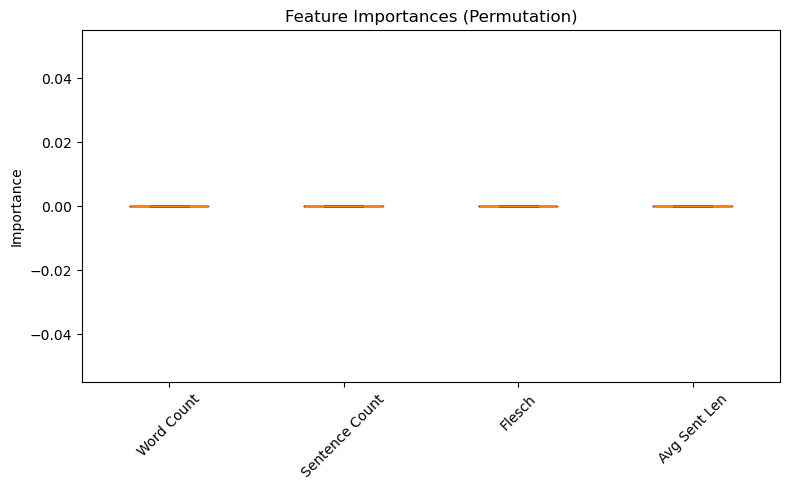

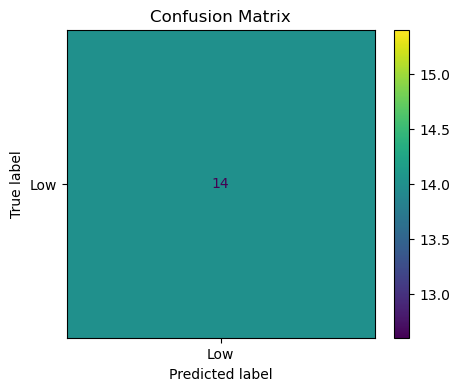

Test dist (True): {'Low': 14}
Test dist (Pred): {'Low': 14}

Sample predictions (first 5 test):
1: Features [[2380.0, 129.0, 30.0, 18.4]] | True: Low | Pred: Low | Correct: True
2: Features [[255.0, 11.0, 30.0, 23.2]] | True: Low | Pred: Low | Correct: True
3: Features [[9039.0, 451.0, 30.0, 20.0]] | True: Low | Pred: Low | Correct: True
4: Features [[3112.0, 129.0, 30.0, 24.1]] | True: Low | Pred: Low | Correct: True
5: Features [[16719.0, 1270.0, 30.0, 13.2]] | True: Low | Pred: Low | Correct: True
Diagnostics saved: importances.png, cm.png.


In [88]:
# Permutation importance
perm = permutation_importance(global_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.boxplot(perm.importances.T, labels=['Word Count', 'Sentence Count', 'Flesch', 'Avg Sent Len'])
ax.set_title('Feature Importances (Permutation)')
ax.set_ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('importances.png', dpi=300)
plt.show()

# Confusion matrix
y_pred_test = global_rf.predict(X_test)
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(le.inverse_transform(y_test), le.inverse_transform(y_pred_test), ax=ax)
ax.set_title('Confusion Matrix')
plt.savefig('cm.png', dpi=300)
plt.show()

print("Test dist (True):", dict(zip(le.classes_, np.bincount(y_test))))
print("Test dist (Pred):", dict(zip(le.classes_, np.bincount(y_pred_test))))

# Samples
print("\nSample predictions (first 5 test):")
for i in range(min(5, len(X_test))):
    feat = [round(x, 1) for x in X_test[i]]
    true_l = le.inverse_transform([y_test[i]])[0]
    pred_l = le.inverse_transform([global_rf.predict([X_test[i]])[0]])[0]
    correct = true_l == pred_l
    print(f"{i+1}: Features [{feat}] | True: {true_l} | Pred: {pred_l} | Correct: {correct}")

print("Diagnostics saved: importances.png, cm.png.")


In [91]:
# Save
joblib.dump(global_rf, 'rf_model.pkl')
joblib.dump(global_le, 'label_encoder.pkl')
joblib.dump(global_model, 'sentence_model.pkl')  # ~80MB
print("Models saved: rf_model.pkl, label_encoder.pkl, sentence_model.pkl")

# Load (for reuse)
# global_rf = joblib.load('rf_model.pkl')
# global_le = joblib.load('label_encoder.pkl')
# global_model = joblib.load('sentence_model.pkl')
# global_label_names = global_le.classes_
# print("Models loaded.")

print("Model persistence complete.")


Models saved: rf_model.pkl, label_encoder.pkl, sentence_model.pkl
Model persistence complete.


In [95]:
pip install streamlit==1.28.1

   ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
    --------------------------------------- 0.1/8.4 MB 4.2 MB/s eta 0:00:02
   -- ------------------------------------- 0.6/8.4 MB 6.1 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.4 MB 9.3 MB/s eta 0:00:01
   --------- ------------------------------ 2.0/8.4 MB 11.4 MB/s eta 0:00:01
   --------------- ------------------------ 3.2/8.4 MB 13.6 MB/s eta 0:00:01
   ------------------- -------------------- 4.0/8.4 MB 14.2 MB/s eta 0:00:01
   ------------------------- -------------- 5.3/8.4 MB 16.2 MB/s eta 0:00:01
   ------------------------------ --------- 6.4/8.4 MB 17.0 MB/s eta 0:00:01
   ---------------------------------- ----- 7.3/8.4 MB 17.3 MB/s eta 0:00:01
   -------------------------------------- - 8.1/8.4 MB 17.2 MB/s eta 0:00:01
   ---------------------------------------  8.4/8.4 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------  8.4/8.4 MB 16.8 MB/s eta 0:00:01
   -------

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda 25.1.1 requires conda-libmamba-solver>=24.11.0, but you have conda-libmamba-solver 24.1.0 which is incompatible.
spyder 5.5.1 requires ipython!=8.17.1,<9.0.0,>=8.13.0; python_version > "3.8", but you have ipython 9.4.0 which is incompatible.
spyder-kernels 2.5.0 requires ipython!=8.17.1,<9,>=8.13.0; python_version > "3.8", but you have ipython 9.4.0 which is incompatible.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.3 which is incompatible.
